# Business Case 4 - Crypto_Forecasting

- Emanuele Aldera, m20210617
- Robin Schmidt, m20210602
- Muhammad Abdullah, m20210655
- Rui Ramos, m20210640

## Importing Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from datetime import timedelta
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from math import ceil
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
close_price = pd.read_csv("data_updated/close.csv", index_col="Date")
high = pd.read_csv("data_updated/high.csv", index_col="Date")
low = pd.read_csv("data_updated/low.csv", index_col="Date")
volume = pd.read_csv("data_updated/volume.csv", index_col="Date")
open_price = pd.read_csv("data_updated/open.csv", index_col="Date")
adj_close = pd.read_csv("data_updated/adj_close.csv", index_col="Date")

In [3]:
crypto = pd.concat([open_price, close_price, high, low, volume, adj_close], axis=1, join="inner")

In [4]:
crypto

ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1723.890015   
2017-05-10       NaN        NaN        NaN        NaN   1756.520020   
2017-05-11       NaN        NaN        NaN        NaN   1780.369995   
2017-05-12       NaN        NaN        NaN        NaN   1845.760010   
2017-05-13       NaN        NaN        NaN        NaN   1723.119995   
...              ...        ...        ...        ...           ...   
2022-05-04  0.771107  17.593870  59.658340  29.114498  37748.011719   
2022-05-05  0.897061  19.871162  67.076157  33.362663  39695.746094   
2022-05-06  0.791065  17.853285  59.121109  28.982380  36573.183594   
2022-05-07  0.783352  17.676107  57.035454  28.464800  36042.503906   
2022-05-08  0.761689  16.511841  55.153175  28.747194  35473.250000   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD    SOL-USD  ...  \
Date                                                                 ...   
2017-05-09          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-10          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-11          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-12          NaN        NaN        NaN        NaN        NaN  ...   
2017-05-13          NaN        NaN        NaN        NaN        NaN  ...   
...                 ...        ...        ...        ...        ...  ...   
2022-05-04  2783.131104  11.121224  82.584396   1.075928  85.841728  ...   
2022-05-05  2940.226562  12.153832  86.159637   1.170986  92.769791  ...   
2022-05-06  2748.931641  10.916577  82.551933   1.064479  84.588493  ...   
2022-05-07  2694.991943  10.799866  77.465630   1.044149  81.766670  ...   
2022-05-08  2637.407227  10.254740  68.271729   1.024481  79.022034  ...   

             ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1755.359985   
2017-05-10       NaN        NaN        NaN        NaN   1787.130005   
2017-05-11       NaN        NaN        NaN        NaN   1848.569946   
2017-05-12       NaN        NaN        NaN        NaN   1724.239990   
2017-05-13       NaN        NaN        NaN        NaN   1804.910034   
...              ...        ...        ...        ...           ...   
2022-05-04  0.896942  19.876862  67.086105  33.363853  39698.371094   
2022-05-05  0.791152  17.853285  59.127441  28.984409  36575.140625   
2022-05-06  0.783359  17.674110  57.034325  28.462557  36040.921875   
2022-05-07  0.761882  16.475998  55.156693  28.750196  35501.953125   
2022-05-08  0.744362  15.785578  51.730221  30.405958  34226.796875   

                ETH-USD   LINK-USD  LUNA1-USD  MATIC-USD    SOL-USD  
Date                                                                 
2017-05-09          NaN        NaN        NaN        NaN        NaN  
2017-05-10          NaN        NaN        NaN        NaN        NaN  
2017-05-11          NaN        NaN        NaN        NaN        NaN  
2017-05-12          NaN        NaN        NaN        NaN        NaN  
2017-05-13          NaN        NaN        NaN        NaN        NaN  
...                 ...        ...        ...        ...        ...  
2022-05-04  2940.644775  12.145610  86.172264   1.171032  92.770851  
2022-05-05  2749.213135  10.917400  82.580406   1.064691  84.596024  
2022-05-06  2694.979736  10.799844  77.464806   1.044133  81.764107  
2022-05-07  2636.093018  10.239905  68.249123   1.021204  78.983421  
2022-05-08  2532.283691  10.044308  64.176682   0.979784  75.536499  

[1826 rows x 60 columns]

In [5]:
ada_usd = crypto["ADA-USD"]
atom_usd = crypto["ATOM-USD"]
avax_usd = crypto["AVAX-USD"]
axs_usd = crypto["AXS-USD"]
btc_usd = crypto["BTC-USD"]
eth_usd = crypto["ETH-USD"]
luna_usd = crypto["LUNA1-USD"]
matic_usd = crypto["MATIC-USD"]
sol_usd = crypto["SOL-USD"]
link_usd= crypto["LINK-USD"]

In [6]:
all_pairs = ['ADA-USD', 'ATOM-USD', 'AVAX-USD', 'AXS-USD', 'LUNA-USD', 'MATIC-USD', 'BTC-USD', 'ETH-USD', 'SOL-USD', "LINK-USD"]
close_price["LUNA-USD"] = close_price["LUNA1-USD"]
close_price.drop("LUNA1-USD", axis=1, inplace=True)

In [7]:
close_price

ADA-USD   ATOM-USD   AVAX-USD    AXS-USD       BTC-USD  \
Date                                                                  
2017-05-09       NaN        NaN        NaN        NaN   1755.359985   
2017-05-10       NaN        NaN        NaN        NaN   1787.130005   
2017-05-11       NaN        NaN        NaN        NaN   1848.569946   
2017-05-12       NaN        NaN        NaN        NaN   1724.239990   
2017-05-13       NaN        NaN        NaN        NaN   1804.910034   
...              ...        ...        ...        ...           ...   
2022-05-04  0.896942  19.876862  67.086105  33.363853  39698.371094   
2022-05-05  0.791152  17.853285  59.127441  28.984409  36575.140625   
2022-05-06  0.783359  17.674110  57.034325  28.462557  36040.921875   
2022-05-07  0.761882  16.475998  55.156693  28.750196  35501.953125   
2022-05-08  0.744362  15.785578  51.730221  30.405958  34226.796875   

                ETH-USD   LINK-USD  MATIC-USD    SOL-USD   LUNA-USD  
Date                                                                 
2017-05-09          NaN        NaN        NaN        NaN        NaN  
2017-05-10          NaN        NaN        NaN        NaN        NaN  
2017-05-11          NaN        NaN        NaN        NaN        NaN  
2017-05-12          NaN        NaN        NaN        NaN        NaN  
2017-05-13          NaN        NaN        NaN        NaN        NaN  
...                 ...        ...        ...        ...        ...  
2022-05-04  2940.644775  12.145610   1.171032  92.770851  86.172264  
2022-05-05  2749.213135  10.917400   1.064691  84.596024  82.580406  
2022-05-06  2694.979736  10.799844   1.044133  81.764107  77.464806  
2022-05-07  2636.093018  10.239905   1.021204  78.983421  68.249123  
2022-05-08  2532.283691  10.044308   0.979784  75.536499  64.176682  

[1826 rows x 10 columns]

In [8]:
ada_usd.columns.values[0] = "Open Price"
ada_usd.columns.values[1] = "Close Price"
ada_usd.columns.values[2] = "Daily High"
ada_usd.columns.values[3] = "Daily Low"
ada_usd.columns.values[4] = "Volume"
ada_usd.columns.values[5] = "Adj Close"

atom_usd.columns.values[0] = "Open Price"
atom_usd.columns.values[1] = "Close Price"
atom_usd.columns.values[2] = "Daily High"
atom_usd.columns.values[3] = "Daily Low"
atom_usd.columns.values[4] = "Volume"
atom_usd.columns.values[5] = "Adj Close"

avax_usd.columns.values[0] = "Open Price"
avax_usd.columns.values[1] = "Close Price"
avax_usd.columns.values[2] = "Daily High"
avax_usd.columns.values[3] = "Daily Low"
avax_usd.columns.values[4] = "Volume"
avax_usd.columns.values[5] = "Adj Close"

axs_usd.columns.values[0] = "Open Price"
axs_usd.columns.values[1] = "Close Price"
axs_usd.columns.values[2] = "Daily High"
axs_usd.columns.values[3] = "Daily Low"
axs_usd.columns.values[4] = "Volume"
axs_usd.columns.values[5] = "Adj Close"

btc_usd.columns.values[0] = "Open Price"
btc_usd.columns.values[1] = "Close Price"
btc_usd.columns.values[2] = "Daily High"
btc_usd.columns.values[3] = "Daily Low"
btc_usd.columns.values[4] = "Volume"
btc_usd.columns.values[5] = "Adj Close"

eth_usd.columns.values[0] = "Open Price"
eth_usd.columns.values[1] = "Close Price"
eth_usd.columns.values[2] = "Daily High"
eth_usd.columns.values[3] = "Daily Low"
eth_usd.columns.values[4] = "Volume"
eth_usd.columns.values[5] = "Adj Close"

luna_usd.columns.values[0] = "Open Price"
luna_usd.columns.values[1] = "Close Price"
luna_usd.columns.values[2] = "Daily High"
luna_usd.columns.values[3] = "Daily Low"
luna_usd.columns.values[4] = "Volume"
luna_usd.columns.values[5] = "Adj Close"

link_usd.columns.values[0] = "Open Price"
link_usd.columns.values[1] = "Close Price"
link_usd.columns.values[2] = "Daily High"
link_usd.columns.values[3] = "Daily Low"
link_usd.columns.values[4] = "Volume"
link_usd.columns.values[5] = "Adj Close"

matic_usd.columns.values[0] = "Open Price"
matic_usd.columns.values[1] = "Close Price"
matic_usd.columns.values[2] = "Daily High"
matic_usd.columns.values[3] = "Daily Low"
matic_usd.columns.values[4] = "Volume"
matic_usd.columns.values[5] = "Adj Close"

sol_usd.columns.values[0] = "Open Price"
sol_usd.columns.values[1] = "Close Price"
sol_usd.columns.values[2] = "Daily High"
sol_usd.columns.values[3] = "Daily Low"
sol_usd.columns.values[4] = "Volume"
sol_usd.columns.values[5] = "Adj Close"

In [9]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    

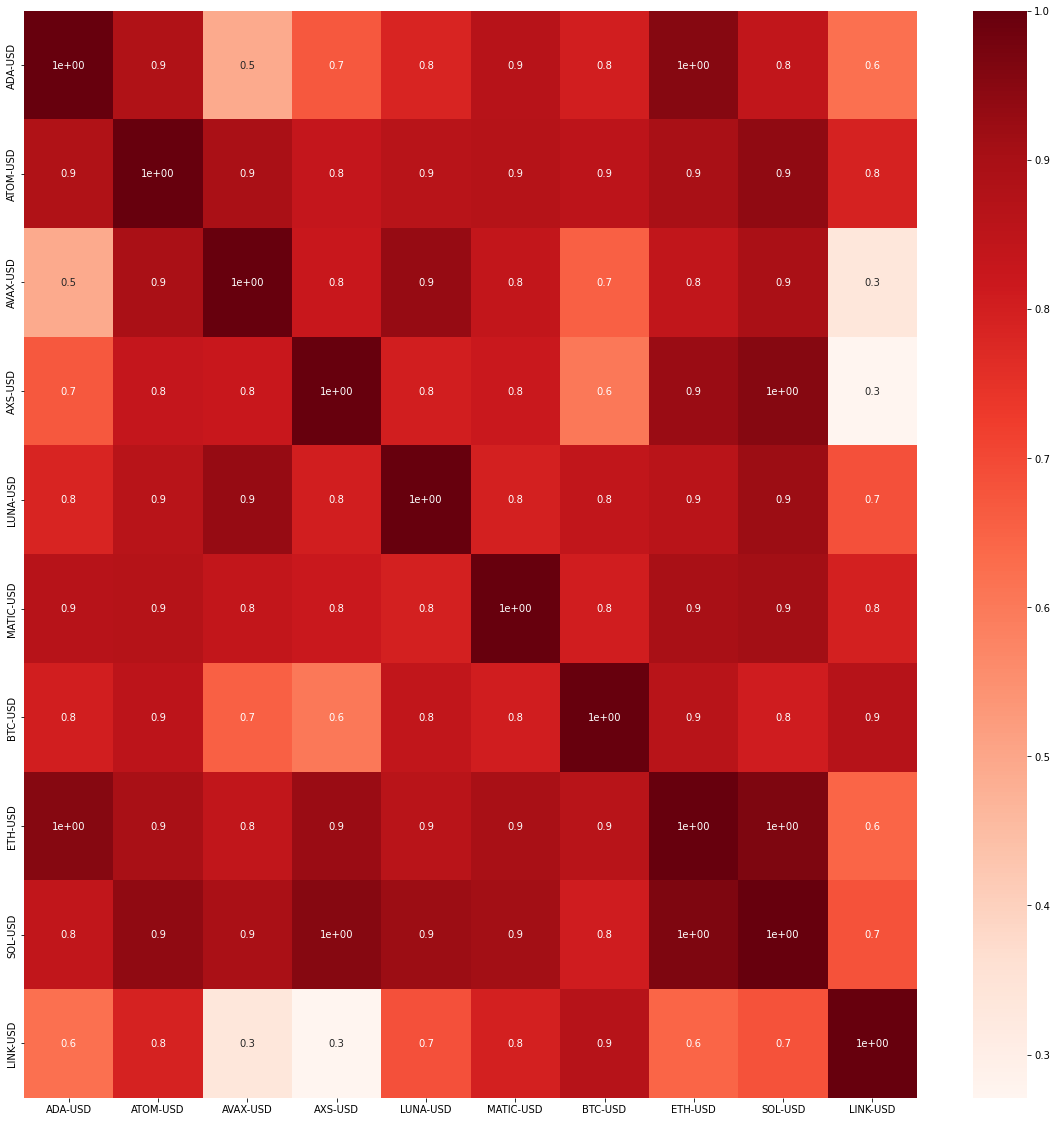

In [10]:
cor_heatmap(np.round(close_price[all_pairs].corr(method = "spearman"),3))

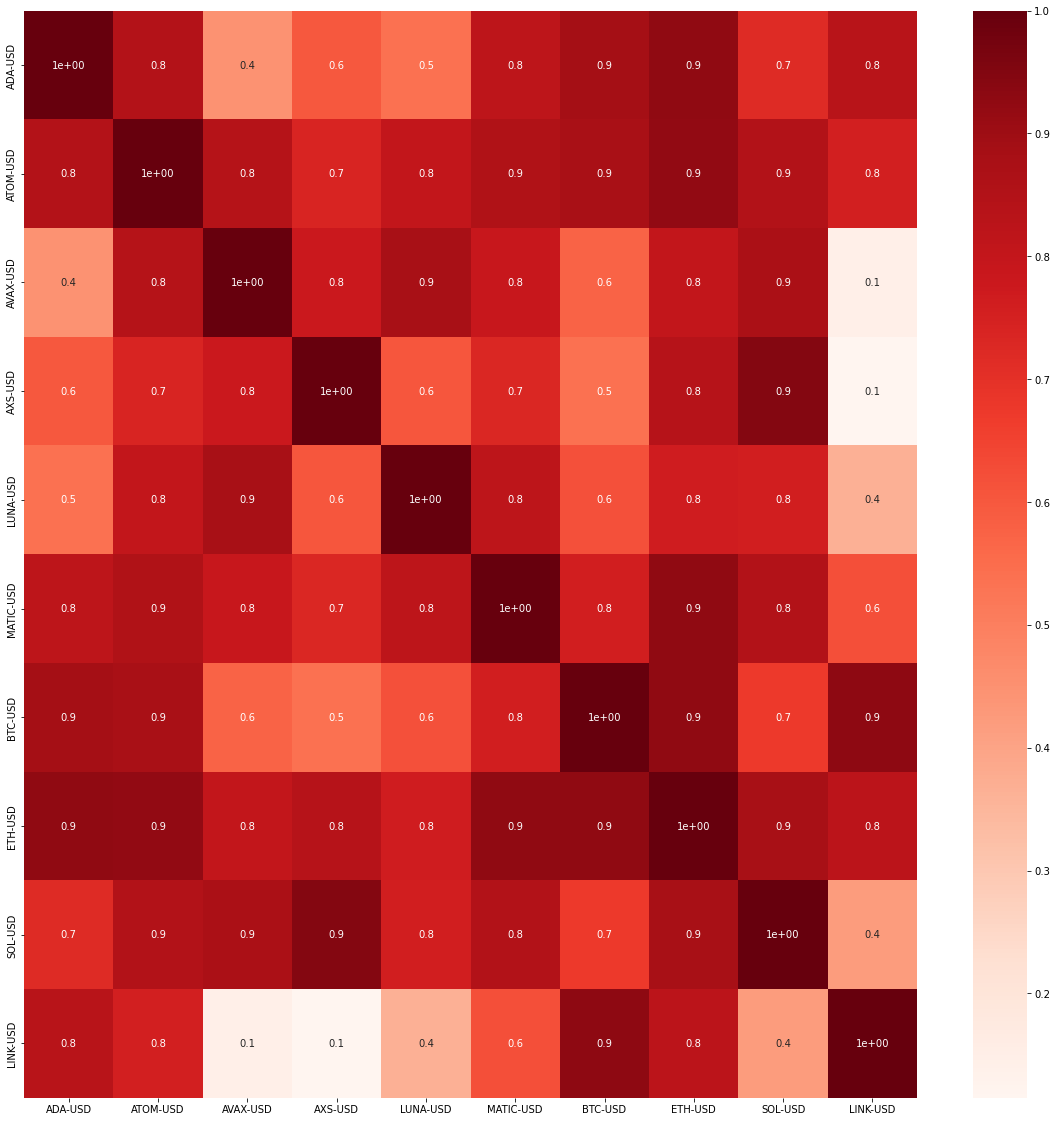

In [11]:
cor_heatmap(np.round(close_price[all_pairs].corr(method = "pearson"),3))

In [12]:
# IMPORTANT NOTE: We can adapt this similar plot for each type of currency 

df = btc_usd.copy()
coin_name = "Bitcoin"

#bollinger window parameters
boll_window = 30
df['sma'] = df['Close Price'].rolling(boll_window).mean()
df['std'] = df['Close Price'].rolling(boll_window).std(ddof = 0)
df.reset_index(inplace=True)

fig = make_subplots(rows = 1, cols = 1)

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=df['Date'],
    open=df['Open Price'], high=df['Daily High'],
    low=df['Daily Low'], close=df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
), #
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=21).mean(),
                mode = 'lines', 
                name = '21SMA',
                line = {'color': '#ffff00'}
            ),
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=50).mean(),
                mode = 'lines',
                name = '50SMA',
                line = {'color': '#00ff11'}
            ), 
            go.Scatter(
                x = df['Date'], 
                y = df["Close Price"].rolling(window=200).mean(),
                mode = 'lines', 
                name = '200SMA',
                line = {'color': '#ff0008'}
            ), 
            go.Scatter(
                x = df['Date'], 
                y = df["sma"],
                mode = 'lines', 
                name = '30SMA',
                line = {'color': '#b300ff'}
            ),
             go.Scatter(
                x = df['Date'], 
                y = df['sma'] + (df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                name = 'upper band',
                opacity = 0.5
            ),
            go.Scatter(
                x = df['Date'], 
                y = df['sma'] - (df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                fill = 'tonexty',
                name = 'lower band',
                opacity = 0.5
            ),
        ]
    ,layout=layout)

fig2 = go.Figure(
            data = go.Bar(
                x = df['Date'],
                y = df["Volume"],
                marker_color = "red"
            )
)
fig.update_layout(
    title = f'The Candlestick graph for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = f'{coin_name}-USD',
    xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')

fig2.update_layout(
    title = f'The Barchart graph showing volume for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = 'Amount of asset traded during the day',
    xaxis_rangeslider_visible = False, #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
    autosize=False,
    width=1000,
    height=1000,
)

fig.show()
fig2.show()

In [13]:
fig = go.Figure(
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),
    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
))

# Scatter
for idx, name in enumerate(close_price):
    fig = fig.add_trace(
        go.Scatter(
            x = close_price.index,
            y = close_price[name],
            name = name,
        )
    )

fig.update_layout(
    title = 'Cryptocurrencies closing prices over time',
    xaxis_title = 'Date',
    yaxis_title = f'Close Price',
    legend_title = 'Cryptocurrencies'
)

fig.update_yaxes(type='log', tickprefix='$')
fig.show()

## LSTM

In [14]:
# Change df to predict other coins - same logic applied later
coin_name = "Bitcoin"
coin_df = btc_usd.copy()
coin_df.dropna(inplace = True, axis = 0) 
coin = coin_df["Close Price"].copy()
coin

Date
2017-05-09     1755.359985
2017-05-10     1787.130005
2017-05-11     1848.569946
2017-05-12     1724.239990
2017-05-13     1804.910034
                  ...     
2022-05-04    39698.371094
2022-05-05    36575.140625
2022-05-06    36040.921875
2022-05-07    35501.953125
2022-05-08    34226.796875
Name: Close Price, Length: 1826, dtype: float64

In [15]:
# scaling for better LSTM performance
scaler = MinMaxScaler()
scaled = scaler.fit_transform(coin.values.reshape(-1,1))
scaled

array([[4.72642343e-04],
       [9.55157086e-04],
       [1.88829084e-03],
       ...,
       [5.21192785e-01],
       [5.13007069e-01],
       [4.93640329e-01]])

In [16]:
#how many days to use for testing
testing_days = ceil(len(scaled)*0.2)
#how many days to go back for predicting one value
prediction_days = ceil(ceil(len(scaled)*0.8)*0.05)
#how many days in the future to predict from the day after the last date (zero means it predicts the day after)
future_day = 1

In [17]:
X, y = [], []

In [18]:
#appending target and input data to be later split
for i in range(prediction_days, len(scaled) - future_day):
    X.append(scaled[i-prediction_days:i, 0])
    y.append(scaled[i + future_day, 0])

In [19]:
X_train = X[:-testing_days]
y_train = y[:-testing_days]

In [20]:
#(train) + (test) + (days to use to predict) = total dataset
len(X_train), testing_days, prediction_days, len(coin)

(1385, 366, 74, 1826)

In [21]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
# Building and training the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
# Prevent overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units = 50))

model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [23]:
model.compile(optimizer = 'adam', loss = 'mse')
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
44/44 [==============================] - 14s 133ms/step - loss: 0.0059
Epoch 2/50
44/44 [==============================] - 6s 139ms/step - loss: 0.0024
Epoch 3/50
44/44 [==============================] - 6s 133ms/step - loss: 0.0020
Epoch 4/50
44/44 [==============================] - 6s 138ms/step - loss: 0.0020
Epoch 5/50
44/44 [==============================] - 6s 145ms/step - loss: 0.0015
Epoch 6/50
44/44 [==============================] - 6s 133ms/step - loss: 0.0017
Epoch 7/50
44/44 [==============================] - 6s 137ms/step - loss: 0.0018
Epoch 8/50
44/44 [==============================] - 6s 135ms/step - loss: 0.0017
Epoch 9/50
44/44 [==============================] - 6s 130ms/step - loss: 0.0014
Epoch 10/50
44/44 [==============================] - 7s 151ms/step - loss: 0.0015
Epoch 11/50
44/44 [==============================] - 6s 142ms/step - loss: 0.0013
Epoch 12/50
44/44 [==============================] - 6s 138ms/step - loss: 0.0014
Epoch 13/50
44/44 [=====

In [24]:
model_inputs = scaled[len(scaled) - prediction_days - testing_days:]

In [25]:
# building test data with same logic as train data, but for last records
X_test = []
for i in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[i-prediction_days:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
X_train.shape, X_test.shape, len(X)

((1385, 74, 1), (366, 74, 1), 1751)

In [27]:
predicted_prices_sc = model.predict(X_test)
#again prices in dollars
predicted_prices = scaler.inverse_transform(predicted_prices_sc.reshape(-1,1))

In [28]:
coin_df["Predicted Price"] = np.NaN

#add next day
coin_df.reset_index(inplace=True)
coin_df["Date"] = pd.to_datetime(coin_df['Date'])
# last date in which we'll predict the  price
prediction_date = coin_df.iloc[len(coin_df)-1]["Date"] + timedelta(days = future_day)
#adding the dates in the "future" to the df
for date in pd.date_range(start=coin_df.iloc[len(coin_df)-1]["Date"],end=prediction_date):
    coin_df = coin_df.append({'Date': date + timedelta(days = future_day)}, ignore_index=True)

#appending predicted prices
coin_df.loc[coin_df.index[-testing_days:], 'Predicted Price'] = predicted_prices
coin_df

Date    Open Price   Close Price    Daily High     Daily Low  \
0    2017-05-09   1723.890015   1755.359985   1833.489990   1716.300049   
1    2017-05-10   1756.520020   1787.130005   1788.439941   1719.099976   
2    2017-05-11   1780.369995   1848.569946   1873.930054   1755.349976   
3    2017-05-12   1845.760010   1724.239990   1856.150024   1694.010010   
4    2017-05-13   1723.119995   1804.910034   1812.989990   1651.079956   
...         ...           ...           ...           ...           ...   
1823 2022-05-06  36573.183594  36040.921875  36624.359375  35482.132812   
1824 2022-05-07  36042.503906  35501.953125  36129.925781  34940.824219   
1825 2022-05-08  35473.250000  34226.796875  35477.484375  33913.957031   
1826 2022-05-09           NaN           NaN           NaN           NaN   
1827 2022-05-10           NaN           NaN           NaN           NaN   

            Volume     Adj Close  Predicted Price  
0     1.167920e+09   1755.359985              NaN  
1     9.157230e+08   1787.130005              NaN  
2     7.994900e+08   1848.569946              NaN  
3     7.409840e+08   1724.239990              NaN  
4     5.796350e+08   1804.910034              NaN  
...            ...           ...              ...  
1823  3.779558e+10  36040.921875     46169.648438  
1824  2.437590e+10  35501.953125     46168.734375  
1825  3.694594e+10  34226.796875     45965.425781  
1826           NaN           NaN     45565.386719  
1827           NaN           NaN     45030.914062  

[1828 rows x 8 columns]

In [29]:
coin_df_scores = coin_df[["Date", "Close Price", "Predicted Price"]].dropna(axis = 0)

r2 = r2_score(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mape = mean_absolute_percentage_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mae = mean_absolute_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mse = mean_squared_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])

scores = pd.DataFrame(index = ["LSTM"])
scores["R2"] = r2
scores["MAPE"] = mape
scores["MAE"] = mae
scores["MSE"] = mse
scores

R2      MAPE          MAE           MSE
LSTM  0.266085  0.153228  6253.568671  5.195195e+07

In [30]:
boll_window = 30
coin_df['sma'] = coin_df['Close Price'].rolling(boll_window).mean()
coin_df['std'] = coin_df['Close Price'].rolling(boll_window).std(ddof = 0)
coin_df.reset_index(inplace=True)

fig = make_subplots(rows = 1, cols = 1)

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=coin_df['Date'],
    open=coin_df['Open Price'], high=coin_df['Daily High'],
    low=coin_df['Daily Low'], close=coin_df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
), #
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=21).mean(),
                mode = 'lines', 
                name = '21SMA',
                line = {'color': '#ffff00'}
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=50).mean(),
                mode = 'lines',
                name = '50SMA',
                line = {'color': '#00ff11'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=200).mean(),
                mode = 'lines', 
                name = '200SMA',
                line = {'color': '#ff0008'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["sma"],
                mode = 'lines', 
                name = '30SMA',
                line = {'color': '#b300ff'}
            ),
             go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] + (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                name = 'upper band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] - (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                fill = 'tonexty',
                name = 'lower band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df["Date"], 
                y = coin_df["Predicted Price"],
                mode = 'lines',
                name = 'Prediction',
                line = {'color': 'black'}
            ),
            go.Scatter(
                x = coin_df["Date"],
                y = coin_df["Close Price"],
                mode = 'lines',
                name = 'Closing Price',
                line = {'color': 'blue'}
            )
        ]
    ,layout=layout)

fig.update_layout(
    title = f'The Candlestick graph for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = f'{coin_name}-USD',
    xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')

fig.show()

## Random Forest

In [31]:
coin_name = "Bitcoin"
coin_df = btc_usd.copy()
coin_df.dropna(inplace = True, axis = 0) 

#how many days to use for testing
testing_days = ceil(len(coin_df)*0.2)
#how many days to go back for predicting one value
prediction_days = ceil(ceil(len(coin_df)*0.8)*0.05)
#how many days in the future to predict from the day after the last date (zero means it predicts the day after)
future_day = 1

coin = coin_df["Close Price"].copy()
coin

Date
2017-05-09     1755.359985
2017-05-10     1787.130005
2017-05-11     1848.569946
2017-05-12     1724.239990
2017-05-13     1804.910034
                  ...     
2022-05-04    39698.371094
2022-05-05    36575.140625
2022-05-06    36040.921875
2022-05-07    35501.953125
2022-05-08    34226.796875
Name: Close Price, Length: 1826, dtype: float64

In [32]:
# Features construction 
coin_df['Open-Close'] = (coin_df['Open Price'] - coin_df['Close Price'])/coin_df['Open Price']
coin_df['High-Low'] = (coin_df['Daily High'] - coin_df['Daily Low'])/coin_df['Daily High']
coin_df['percent_change'] = coin_df['Adj Close'].pct_change()
coin_df['std_5'] = coin_df['percent_change'].rolling(5).std()
coin_df['ret_5'] = coin_df['percent_change'].rolling(5).mean()
#dropping first 5 values having std_5 and ret_5 values to NaN
coin_df.dropna(inplace=True)

coin_df["Predicted Price"] = np.NaN

#add next day
coin_df.reset_index(inplace=True)
coin_df["Date"] = pd.to_datetime(coin_df['Date'])
prediction_date = coin_df.iloc[len(coin_df)-1]["Date"] + timedelta(days = future_day)
for date in pd.date_range(start=coin_df.iloc[len(coin_df)-1]["Date"],end=prediction_date):
    coin_df = coin_df.append({'Date': date + timedelta(days = future_day)}, ignore_index=True)
coin_df

In [33]:
# X is the input variable
X = coin_df[['Close Price', "Open Price", 'High-Low', 'std_5', 'ret_5']]
#shift is needed to predict values in future based on training data
y = coin_df["Close Price"].shift(1)

In [34]:
X, y.head(10)

(       Close Price    Open Price  High-Low     std_5     ret_5
 0      1808.910034   1800.859985  0.029922  0.044701  0.006845
 1      1738.430054   1808.439941  0.057513  0.048252 -0.004568
 2      1734.449951   1741.699951  0.055657  0.043395 -0.011901
 3      1839.089966   1726.729980  0.108441  0.040093  0.013616
 4      1888.650024   1818.699951  0.051122  0.036840  0.009649
 ...            ...           ...       ...       ...       ...
 1818  36040.921875  36573.183594  0.031188  0.046767 -0.012066
 1819  35501.953125  36042.503906  0.032912  0.046143 -0.015370
 1820  34226.796875  35473.250000  0.044071  0.047080 -0.018510
 1821           NaN           NaN       NaN       NaN       NaN
 1822           NaN           NaN       NaN       NaN       NaN
 
 [1823 rows x 5 columns],
 0            NaN
 1    1808.910034
 2    1738.430054
 3    1734.449951
 4    1839.089966
 5    1888.650024
 6    1987.709961
 7    2084.729980
 8    2041.199951
 9    2173.399902
 Name: Close Price, dtyp

In [35]:
#not first record since has target NaN
X_train = X[1:-testing_days]
y_train = y[1:-testing_days]
#not last two records since X has NaN
X_test = X[-testing_days:-2]
y_test = y[-testing_days:-2]
len(X_train), testing_days, prediction_days, len(coin_df)

(1456, 366, 74, 1823)

In [36]:
X_train, y_train

(       Close Price    Open Price  High-Low     std_5     ret_5
 1      1738.430054   1808.439941  0.057513  0.048252 -0.004568
 2      1734.449951   1741.699951  0.055657  0.043395 -0.011901
 3      1839.089966   1726.729980  0.108441  0.040093  0.013616
 4      1888.650024   1818.699951  0.051122  0.036840  0.009649
 5      1987.709961   1897.369995  0.057006  0.040929  0.019695
 ...            ...           ...       ...       ...       ...
 1452  57424.007812  53252.164062  0.085343  0.052401 -0.000041
 1453  56396.515625  57441.308594  0.051073  0.052977 -0.003889
 1454  57356.402344  56413.953125  0.056048  0.052669  0.003655
 1455  58803.777344  57352.765625  0.041864  0.053560  0.006692
 1456  58232.316406  58877.390625  0.046087  0.037265  0.018268
 
 [1456 rows x 5 columns],
 1        1808.910034
 2        1738.430054
 3        1734.449951
 4        1839.089966
 5        1888.650024
             ...     
 1452    53333.539062
 1453    57424.007812
 1454    56396.515625
 1455 

In [37]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(random_state=5)

In [38]:
# Create the model on train dataset
model = clf.fit(X_train, y_train)

In [39]:
predicted_prices = model.predict(X_test)

coin_df.loc[coin_df.index[-testing_days+2:], 'Predicted Price'] = predicted_prices
coin_df

Date    Open Price   Close Price    Daily High     Daily Low  \
0    2017-05-14   1800.859985   1808.910034   1831.420044   1776.619995   
1    2017-05-15   1808.439941   1738.430054   1812.800049   1708.540039   
2    2017-05-16   1741.699951   1734.449951   1785.939941   1686.540039   
3    2017-05-17   1726.729980   1839.089966   1864.050049   1661.910034   
4    2017-05-18   1818.699951   1888.650024   1904.479980   1807.119995   
...         ...           ...           ...           ...           ...   
1818 2022-05-06  36573.183594  36040.921875  36624.359375  35482.132812   
1819 2022-05-07  36042.503906  35501.953125  36129.925781  34940.824219   
1820 2022-05-08  35473.250000  34226.796875  35477.484375  33913.957031   
1821 2022-05-09           NaN           NaN           NaN           NaN   
1822 2022-05-10           NaN           NaN           NaN           NaN   

            Volume     Adj Close  Open-Close  High-Low  percent_change  \
0     4.371960e+08   1808.910034   -0.004470  0.029922        0.002216   
1     7.315290e+08   1738.430054    0.038713  0.057513       -0.038963   
2     9.590450e+08   1734.449951    0.004163  0.055657       -0.002289   
3     1.064730e+09   1839.089966   -0.065071  0.108441        0.060330   
4     8.943210e+08   1888.650024   -0.038462  0.051122        0.026948   
...            ...           ...         ...       ...             ...   
1818  3.779558e+10  36040.921875    0.014553  0.031188       -0.014606   
1819  2.437590e+10  35501.953125    0.014998  0.032912       -0.014954   
1820  3.694594e+10  34226.796875    0.035138  0.044071       -0.035918   
1821           NaN           NaN         NaN       NaN             NaN   
1822           NaN           NaN         NaN       NaN             NaN   

         std_5     ret_5  Predicted Price  
0     0.044701  0.006845              NaN  
1     0.048252 -0.004568              NaN  
2     0.043395 -0.011901              NaN  
3     0.040093  0.013616              NaN  
4     0.036840  0.009649              NaN  
...        ...       ...              ...  
1818  0.046767 -0.012066     37810.558750  
1819  0.046143 -0.015370     39199.867813  
1820  0.047080 -0.018510     36717.954336  
1821       NaN       NaN     36053.657773  
1822       NaN       NaN     35688.240664  

[1823 rows x 13 columns]

In [40]:
#check if first line works, otherwise decomment second one (if it works change arguments for all of them)
coin_df_scores = coin_df[["Date", "Close Price", "Predicted Price"]].dropna(axis = 0)

r2 = r2_score(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
# r2 = r2_score(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mae = mean_absolute_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mse = mean_squared_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])

scores = pd.DataFrame(index = ["Random Forest"])
scores["R2"] = r2
scores["MAPE"] = mape
scores["MAE"] = mae
scores["MSE"] = mse
scores

R2      MAPE          MAE           MSE
Random Forest  0.894053  0.049466  2169.138348  7.461792e+06

In [41]:
boll_window = 30
coin_df['sma'] = coin_df['Close Price'].rolling(boll_window).mean()
coin_df['std'] = coin_df['Close Price'].rolling(boll_window).std(ddof = 0)
coin_df.reset_index(inplace=True)

fig = make_subplots(rows = 1, cols = 1)

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=coin_df['Date'],
    open=coin_df['Open Price'], high=coin_df['Daily High'],
    low=coin_df['Daily Low'], close=coin_df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
), #
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=21).mean(),
                mode = 'lines', 
                name = '21SMA',
                line = {'color': '#ffff00'}
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=50).mean(),
                mode = 'lines',
                name = '50SMA',
                line = {'color': '#00ff11'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=200).mean(),
                mode = 'lines', 
                name = '200SMA',
                line = {'color': '#ff0008'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["sma"],
                mode = 'lines', 
                name = '30SMA',
                line = {'color': '#b300ff'}
            ),
             go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] + (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                name = 'upper band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] - (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                fill = 'tonexty',
                name = 'lower band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df["Date"], 
                y = coin_df["Predicted Price"],
                mode = 'lines',
                name = 'Prediction',
                line = {'color': 'black'}
            ),
            go.Scatter(
                x = coin_df["Date"],
                y = coin_df["Close Price"],
                mode = 'lines',
                name = 'Closing Price',
                line = {'color': 'blue'}
            )
        ]
    ,layout=layout)

fig.update_layout(
    title = f'The Candlestick graph for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = f'{coin_name}-USD',
    xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)
fig.update_yaxes(tickprefix='$')

fig.show()

## XGBoost Model

In [42]:
# logic almost similar to LSTM

coin_name = "Bitcoin"
coin_df = btc_usd.copy()
coin_df.dropna(inplace = True, axis = 0)

future_day = 1

#add next day
coin_df.reset_index(inplace=True)
coin_df["Date"] = pd.to_datetime(coin_df['Date'])
prediction_date = coin_df.iloc[len(coin_df)-1]["Date"] + timedelta(days = future_day)
for date in pd.date_range(start=coin_df.iloc[len(coin_df)-1]["Date"],end=prediction_date):
    coin_df = coin_df.append({'Date': date + timedelta(days = future_day)}, ignore_index=True)

coin = coin_df.copy()
coin = coin["Close Price"]
coin

0        1755.359985
1        1787.130005
2        1848.569946
3        1724.239990
4        1804.910034
            ...     
1823    36040.921875
1824    35501.953125
1825    34226.796875
1826             NaN
1827             NaN
Name: Close Price, Length: 1828, dtype: float64

In [43]:
# scaler=MinMaxScaler(feature_range=(0,1))
# scaled=scaler.fit_transform(np.array(coin).reshape(-1,1))
# print(scaled.shape)

# test_size=365
# training_size=len(scaled) - test_size
# train_data,test_data=scaled[0:training_size,:],scaled[training_size:len(scaled),:1]
# print("train_data: ", train_data.shape)
# print("test_data: ", test_data.shape)

# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-time_step-1):
#         a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
#         dataX.append(a)
#         dataY.append(dataset[i + time_step, 0])
#     return np.array(dataX), np.array(dataY)

# time_step = 60
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, y_test = create_dataset(test_data, time_step)

# print("X_train: ", X_train.shape)
# print("y_train: ", y_train.shape)
# print("X_test: ", X_test.shape)
# print("y_test", y_test.shape)

# X_train, y_train

In [44]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(coin.values.reshape(-1,1))
scaled
#how many days to use for testing
testing_days = ceil(len(scaled)*0.2)
#how many days to go back for predicting one value
prediction_days = ceil(ceil(len(scaled)*0.8)*0.05)
#how many days in the future to predict from the day after the last date (zero means it predicts the day after)
future_day = 1

X, y = [], []

for i in range(prediction_days, len(scaled) - future_day):
    X.append(scaled[i-prediction_days:i, 0])
    y.append(scaled[i + future_day, 0])

X_train = X[:-testing_days]
y_train = y[:-testing_days]

model_inputs = scaled[len(scaled) - prediction_days - testing_days:]

X_test = []
for i in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[i-prediction_days:i, 0])

In [45]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [46]:
# actual_prices = y_test
predicted_prices_sc = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices_sc.reshape(-1,1))
predicted_prices
coin_df["Predicted Price"] = np.NaN
coin_df.loc[coin_df.index[-len(predicted_prices):], 'Predicted Price'] = predicted_prices
coin_df

Date    Open Price   Close Price    Daily High     Daily Low  \
0    2017-05-09   1723.890015   1755.359985   1833.489990   1716.300049   
1    2017-05-10   1756.520020   1787.130005   1788.439941   1719.099976   
2    2017-05-11   1780.369995   1848.569946   1873.930054   1755.349976   
3    2017-05-12   1845.760010   1724.239990   1856.150024   1694.010010   
4    2017-05-13   1723.119995   1804.910034   1812.989990   1651.079956   
...         ...           ...           ...           ...           ...   
1823 2022-05-06  36573.183594  36040.921875  36624.359375  35482.132812   
1824 2022-05-07  36042.503906  35501.953125  36129.925781  34940.824219   
1825 2022-05-08  35473.250000  34226.796875  35477.484375  33913.957031   
1826 2022-05-09           NaN           NaN           NaN           NaN   
1827 2022-05-10           NaN           NaN           NaN           NaN   

            Volume     Adj Close  Predicted Price  
0     1.167920e+09   1755.359985              NaN  
1     9.157230e+08   1787.130005              NaN  
2     7.994900e+08   1848.569946              NaN  
3     7.409840e+08   1724.239990              NaN  
4     5.796350e+08   1804.910034              NaN  
...            ...           ...              ...  
1823  3.779558e+10  36040.921875     49355.242188  
1824  2.437590e+10  35501.953125     49285.000000  
1825  3.694594e+10  34226.796875     49355.242188  
1826           NaN           NaN     49355.242188  
1827           NaN           NaN     48835.125000  

[1828 rows x 8 columns]

In [47]:
coin_df_scores = coin_df[["Date", "Close Price", "Predicted Price"]].dropna(axis = 0)

r2 = r2_score(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
# r2 = r2_score(actual_prices, predicted_prices)
mape = mean_absolute_percentage_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mae = mean_absolute_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])
mse = mean_squared_error(coin_df_scores["Close Price"], coin_df_scores["Predicted Price"])

scores = pd.DataFrame(index = ["XGBoost"])
scores["R2"] = r2
scores["MAPE"] = mape
scores["MAE"] = mae
scores["MSE"] = mse
scores

R2      MAPE          MAE           MSE
XGBoost -0.056451  0.182975  7307.510517  7.478341e+07

In [48]:
boll_window = 30
coin_df['sma'] = coin_df['Close Price'].rolling(boll_window).mean()
coin_df['std'] = coin_df['Close Price'].rolling(boll_window).std(ddof = 0)
coin_df.reset_index(inplace=True)

fig = make_subplots(rows = 1, cols = 1)

layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,

    xaxis= go.layout.XAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    yaxis= go.layout.YAxis(linecolor = 'black',
                          linewidth = 1,
                          mirror = True),

    margin=go.layout.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
        pad = 4
    )
)

fig = go.Figure(

    data=[go.Candlestick(
    x=coin_df['Date'],
    open=coin_df['Open Price'], high=coin_df['Daily High'],
    low=coin_df['Daily Low'], close=coin_df['Close Price'],
    increasing_line_color= 'Green', decreasing_line_color= 'Red'
), #
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=21).mean(),
                mode = 'lines', 
                name = '21SMA',
                line = {'color': '#ffff00'}
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=50).mean(),
                mode = 'lines',
                name = '50SMA',
                line = {'color': '#00ff11'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["Close Price"].rolling(window=200).mean(),
                mode = 'lines', 
                name = '200SMA',
                line = {'color': '#ff0008'}
            ), 
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df["sma"],
                mode = 'lines', 
                name = '30SMA',
                line = {'color': '#b300ff'}
            ),
             go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] + (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                name = 'upper band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df['Date'], 
                y = coin_df['sma'] - (coin_df['std'] * 2),
                line_color = 'gray',
                line = {'dash': 'dash'},
                fill = 'tonexty',
                name = 'lower band',
                opacity = 0.5
            ),
            go.Scatter(
                x = coin_df["Date"], 
                y = coin_df["Predicted Price"],
                mode = 'lines',
                name = 'Prediction',
                line = {'color': 'black'}
            ),
            go.Scatter(
                x = coin_df["Date"],
                y = coin_df["Close Price"],
                mode = 'lines',
                name = 'Closing Price',
                line = {'color': 'blue'}
            )
        ]
    ,layout=layout)

fig.update_layout(
    title = f'The Candlestick graph for {coin_name}',
    xaxis_title = 'Date',
    yaxis_title = f'{coin_name}-USD',
    xaxis_rangeslider_visible = False #DEFAULT TRUE, WHILE TAKING SCREENSHOT WE PUT IT TO FALSE
)

fig.update_yaxes(tickprefix='$')
fig.show()